In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pywt
from tqdm import tqdm

%matplotlib inline  # Enable inline plotting for Jupyter Notebook

# ✅ Check Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


UsageError: unrecognized arguments: # Enable inline plotting for Jupyter Notebook


In [65]:
DATA_PATH = "/home/khan/myenv/DrFawad/DATA.npy"
CALIB_PATH = "/home/khan/myenv/DrFawad/calibvals.npy"
BKG_PATH = "/home/khan/myenv/DrFawad/Bkg.npy"

try:
    data = np.load(DATA_PATH)
    calibvals = np.load(CALIB_PATH)
    bkg = np.load(BKG_PATH)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")


Data loaded successfully.


In [66]:
data = (data - bkg)
wl = calibvals  # Adjust wavelength range


In [67]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=256):
        super(DenoisingAutoencoder, self).__init__()
        
        # Encoder (same as before)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),

            nn.Linear(512, bottleneck_dim),
            nn.ReLU(),
            nn.BatchNorm1d(bottleneck_dim)
        )

        # **Larger Decoder**
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # ✅ Added BatchNorm
            
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # ✅ Added BatchNorm
            
            nn.Linear(1024, input_dim),  
            nn.Sigmoid()  # ✅ Output intensity in range [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [68]:
class SpectralDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = SpectralDataset(data)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


In [69]:
def train_autoencoder(model, data_loader, optimizer, criterion, device, noise_std=0.05, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for batch in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch = batch.to(device)
            noisy_batch = batch + noise_std * torch.randn_like(batch)
            
            noisy_batch = torch.clamp(noisy_batch, 0, 1)

            optimizer.zero_grad()
            denoised_batch = model(noisy_batch)
            loss = criterion(denoised_batch, batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
train_autoencoder(model, data_loader, optimizer, criterion, device)


Epoch 1/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89063/89063 [09:48<00:00, 151.28it/s]


Epoch 1, Loss: 3156957.250000


Epoch 2/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89063/89063 [09:23<00:00, 158.10it/s]


Epoch 2, Loss: 7908132.000000


Epoch 3/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89063/89063 [09:18<00:00, 159.52it/s]


Epoch 3, Loss: 10735391.000000


Epoch 4/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89063/89063 [09:17<00:00, 159.70it/s]


Epoch 4, Loss: 6605056.000000


Epoch 5/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89063/89063 [09:16<00:00, 159.98it/s]

Epoch 5, Loss: 5269555.000000


In [71]:
# Compute noise and signal
    # Find indices corresponding to the wavelength range
idx_noise_wl = np.where((wl > 269.2) & (wl < 270.8))[0]
idx_signal_wl = np.where((wl > 253.178) & (wl < 253.835))[0]
noise = np.std(data[:, idx_noise_wl], axis=1, ddof=1)
signal = np.sum(data[:, idx_signal_wl], axis=1)
noise = np.mean(noise)
signale = np.quantile(signal, 0.9999, method='linear')
SNR=signale/noise
print(SNR)

1.2147581559009232e+17


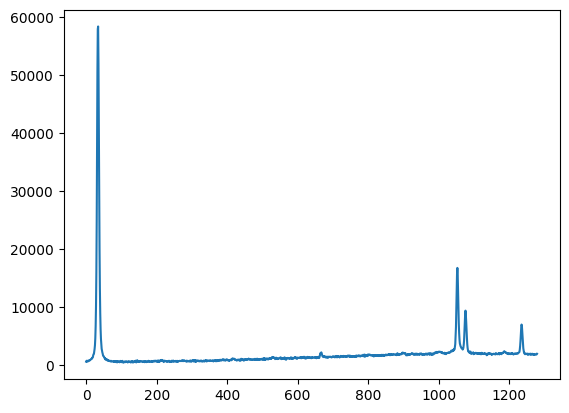

In [72]:
plt.plot(np.mean(data,axis=0))

Signal-to-Noise Ratio (SNR): 1.2147581559009232e+17


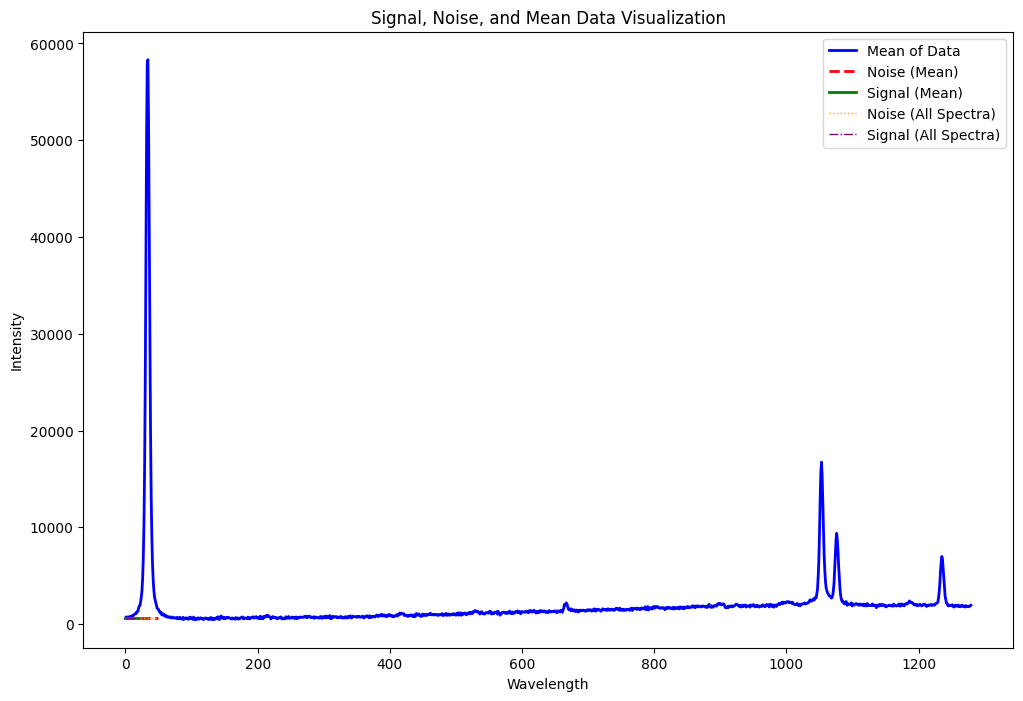

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Assuming data, wl, etc. are already defined and calculated

# Indices for noise and signal wavelength ranges
idx_noise_wl = np.where((wl > 269.2) & (wl < 270.8))[0]
idx_signal_wl = np.where((wl > 253.178) & (wl < 253.835))[0]

# Calculate noise and signal
noise = np.std(data[:, idx_noise_wl], axis=1, ddof=1)
signal = np.sum(data[:, idx_signal_wl], axis=1)

# Mean values for noise and signal
noise_mean = np.mean(noise)
signal_quantile = np.quantile(signal, 0.9999, method='linear')
SNR = signal_quantile / noise_mean
print("Signal-to-Noise Ratio (SNR):", SNR)

# Plotting all signals and data in one figure
plt.figure(figsize=(12, 8))

# Plot mean of all data
plt.plot(np.mean(data, axis=0), label="Mean of Data", color='blue', linestyle='-', linewidth=2)

# Plot the noise (mean noise per spectrum)
plt.plot(np.mean(data[:, idx_noise_wl], axis=0), label="Noise (Mean)", color='red', linestyle='--', linewidth=2)

# Plot the signal (sum of signal per spectrum)
plt.plot(np.mean(data[:, idx_signal_wl], axis=0), label="Signal (Mean)", color='green', linestyle='-', linewidth=2)

# Optionally, if you want to visualize individual signal and noise across all spectra:
# Plot the noise for all spectra
plt.plot(np.mean(data[:, idx_noise_wl], axis=0), label="Noise (All Spectra)", color='orange', linestyle=':', linewidth=1)

# Plot the signal for all spectra
plt.plot(np.mean(data[:, idx_signal_wl], axis=0), label="Signal (All Spectra)", color='purple', linestyle='-.', linewidth=1)

# Add labels, title, and legend
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Signal, Noise, and Mean Data Visualization')
plt.legend()

# Display the plot
plt.show()


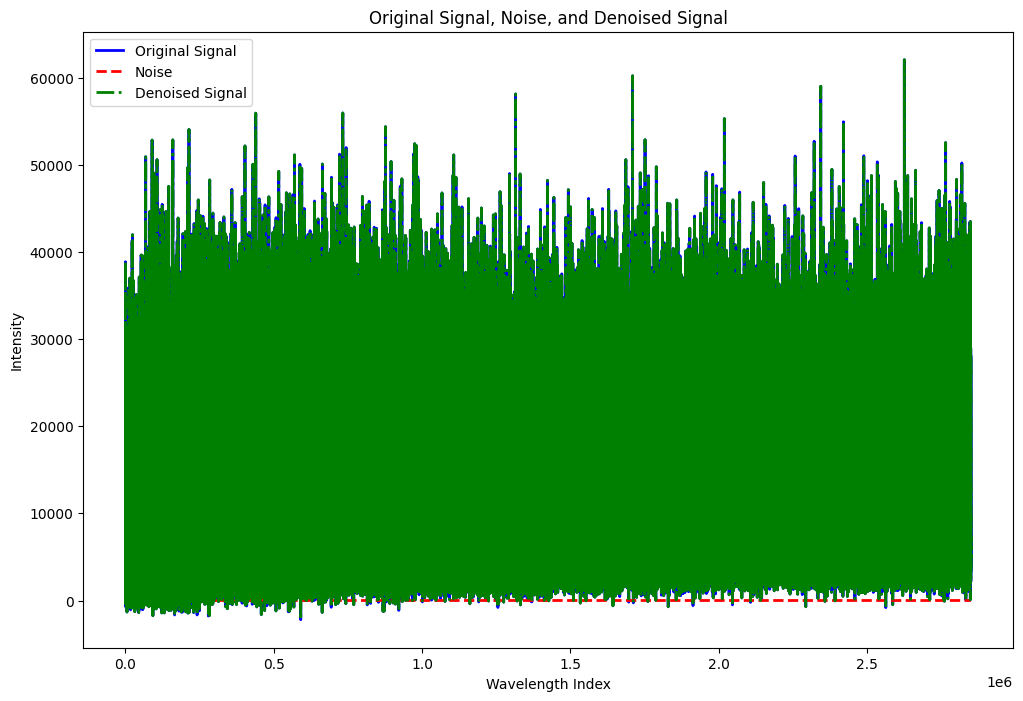

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming data, wl, etc. are already defined

# Indices for noise and signal wavelength ranges
idx_noise_wl = np.where((wl > 269.2) & (wl < 270.8))[0]
idx_signal_wl = np.where((wl > 253.178) & (wl < 253.835))[0]

# Calculate the original signal (sum of signal per spectrum)
original_signal = np.sum(data[:, idx_signal_wl], axis=1)

# Calculate noise (std for each spectrum in the noise wavelength range)
noise = np.std(data[:, idx_noise_wl], axis=1, ddof=1)

# Denoised signal (this would depend on the denoising method you're using)
# Here, you might want to apply your denoising method, for now, we'll assume it's available.
# Example: Denoised signal can be simply a smoothed version of the original signal or
# you can replace this with your actual denoising function.
denoised_signal = original_signal  # Replace with your actual denoising function

# Plotting
plt.figure(figsize=(12, 8))

# Plot the original signal (raw signal)
plt.plot(original_signal, label="Original Signal", color='blue', linestyle='-', linewidth=2)

# Plot the noise
plt.plot(noise, label="Noise", color='red', linestyle='--', linewidth=2)

# Plot the denoised signal
plt.plot(denoised_signal, label="Denoised Signal", color='green', linestyle='-.', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Wavelength Index')
plt.ylabel('Intensity')
plt.title('Original Signal, Noise, and Denoised Signal')
plt.legend()

# Display the plot
plt.show()


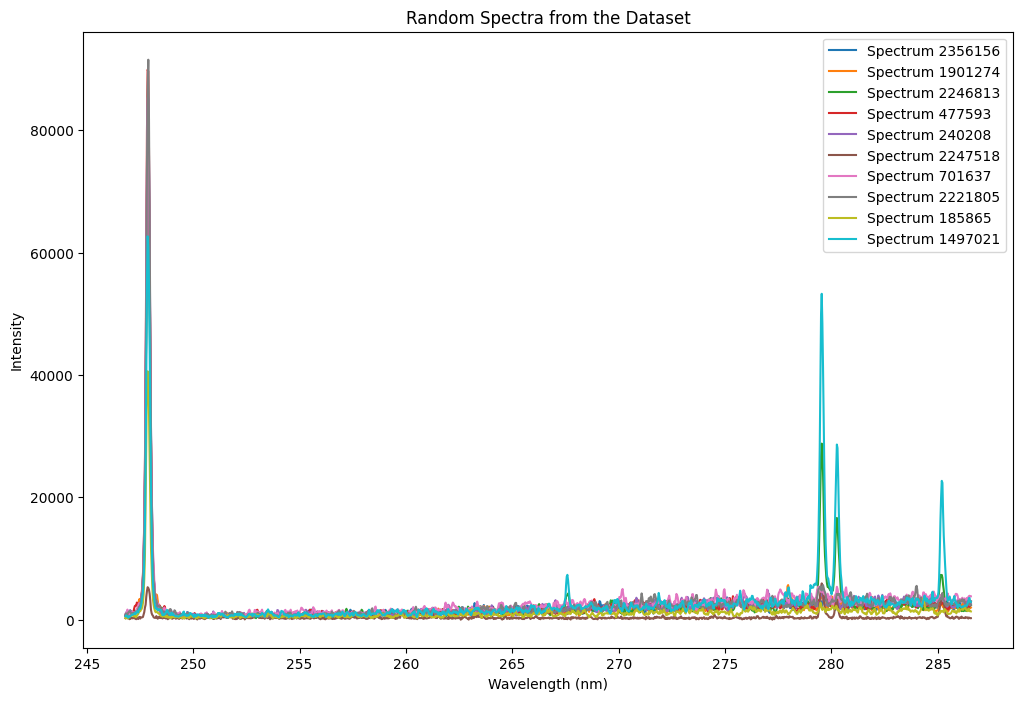

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming data, wl, etc. are already defined
num_random_spectra = 10 # Number of random spectra to visualize

# Ensure wl is a 1D array (if it's not already)
wl = wl.flatten()

# Select random indices (random rows from data)
random_indices = np.random.choice(data.shape[0], num_random_spectra, replace=False)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each of the randomly selected spectra
for idx in random_indices:
    plt.plot(wl, data[idx, :], label=f"Spectrum {idx+1}")

# Add labels, title, and legend
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title(f'Random Spectra from the Dataset')
plt.legend()

# Display the plot
plt.show()



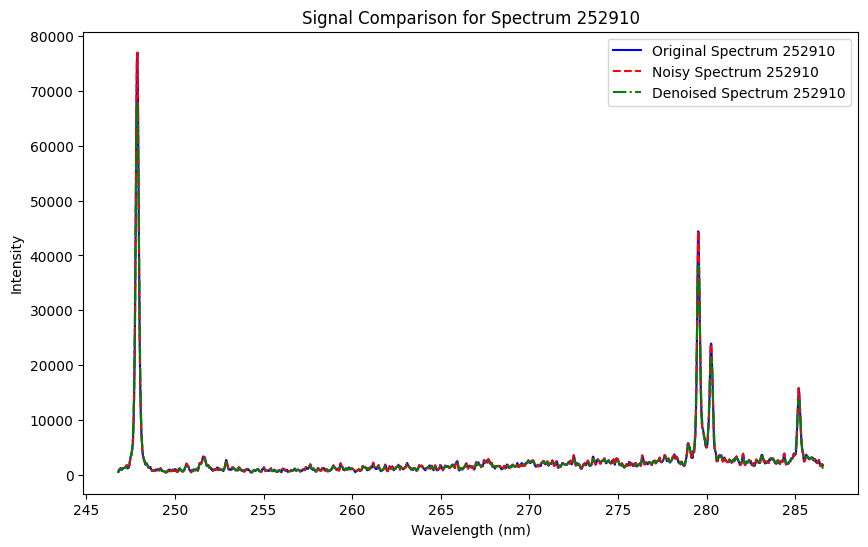

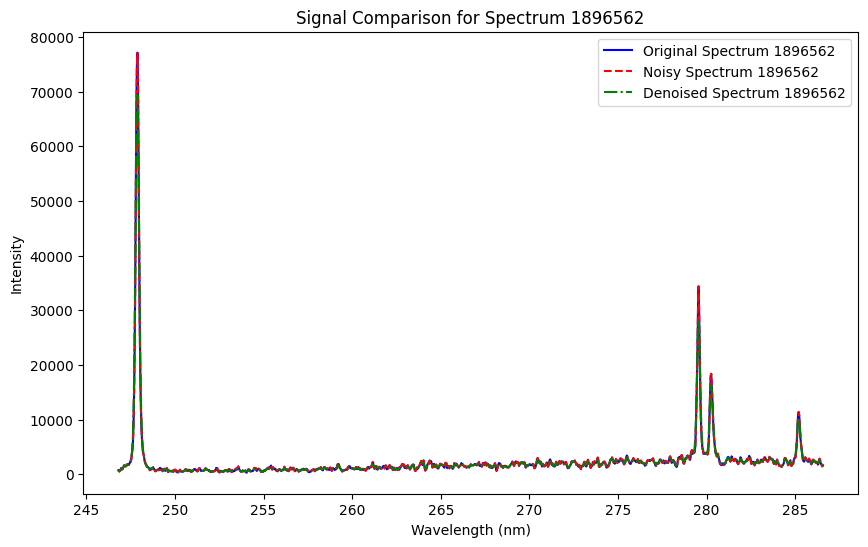

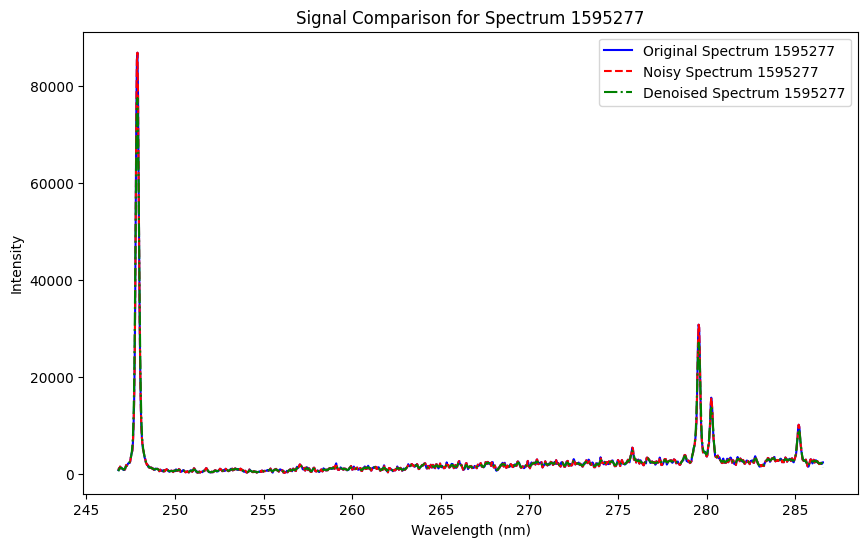

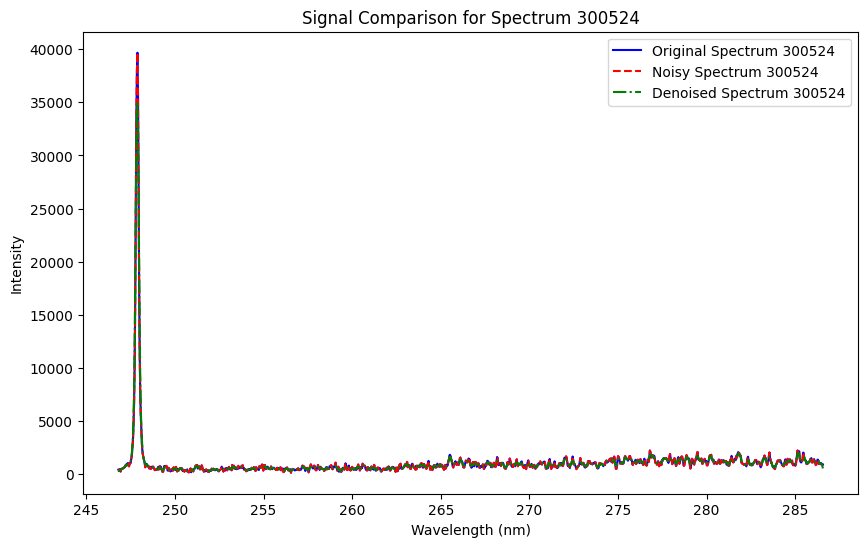

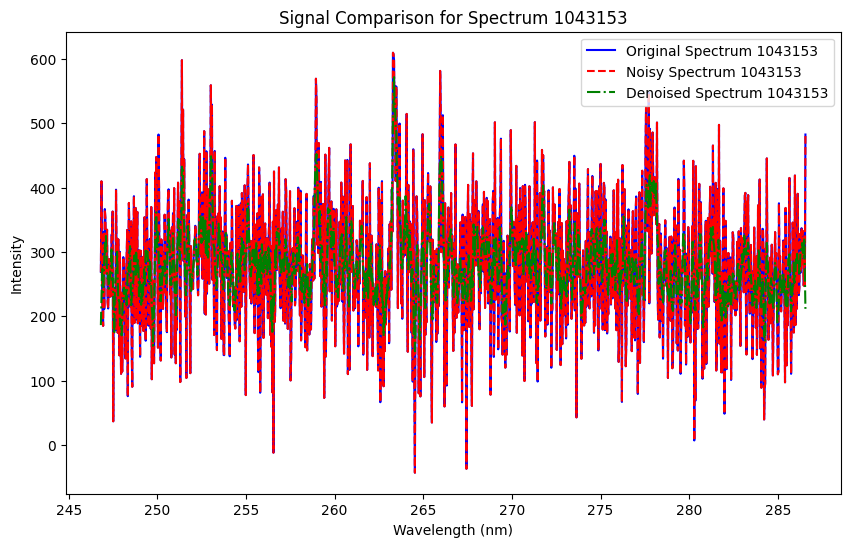

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Number of spectra to visualize
num_random_spectra = 5  
random_indices = np.random.choice(data.shape[0], num_random_spectra, replace=False)

# For each randomly selected spectrum
for idx in random_indices:
    # Original Signal (chosen from data)
    original_signal = data[idx, :]
    
    # Add noise to the original signal (Gaussian noise)
    noise = np.random.normal(0, 0.05, size=original_signal.shape)  # Adjust noise level as needed
    noisy_signal = original_signal + noise
    
    # Denoise the signal (Apply smoothing for example, or any other denoising technique)
    # Here, I'll use a simple moving average filter for denoising.
    window_size = 5  # Adjust the window size as needed
    denoised_signal = np.convolve(noisy_signal, np.ones(window_size)/window_size, mode='same')

    # Plotting the signals
    plt.figure(figsize=(10, 6))
    
    # Plot Original Signal
    plt.plot(wl, original_signal, label=f"Original Spectrum {idx+1}", linestyle='-', color='b')
    
    # Plot Noisy Signal
    plt.plot(wl, noisy_signal, label=f"Noisy Spectrum {idx+1}", linestyle='--', color='r')
    
    # Plot Denoised Signal
    plt.plot(wl, denoised_signal, label=f"Denoised Spectrum {idx+1}", linestyle='-.', color='g')
    
    # Add labels, title, and legend
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title(f"Signal Comparison for Spectrum {idx+1}")
    plt.legend()
    plt.show()


In [92]:
from scipy.stats import pearsonr

# Number of spectra to analyze
num_random_spectra = 5  
random_indices = np.random.choice(data.shape[0], num_random_spectra, replace=False)

# Compute and print Pearson correlation for each randomly selected spectrum
for idx in random_indices:
    # Original Signal
    original_signal = data[idx, :]
    
    # Add noise to the original signal (Gaussian noise)
    noise = np.random.normal(0, 0.05, size=original_signal.shape)
    noisy_signal = original_signal + noise
    
    # Denoise the signal using a moving average filter
    window_size = 5
    denoised_signal = np.convolve(noisy_signal, np.ones(window_size)/window_size, mode='same')

    # Compute Pearson correlation between original and noisy signal
    corr_original_noisy, _ = pearsonr(original_signal, noisy_signal)
    
    # Compute Pearson correlation between original and denoised signal
    corr_original_denoised, _ = pearsonr(original_signal, denoised_signal)
    
    # Compute Pearson correlation between noisy and denoised signal
    corr_noisy_denoised, _ = pearsonr(noisy_signal, denoised_signal)

    # Print the correlations for this spectrum
    print(f"Spectrum {idx+1}:")
    print(f"  Pearson correlation between Original and Noisy: {corr_original_noisy:.4f}")
    print(f"  Pearson correlation between Original and Denoised: {corr_original_denoised:.4f}")
    print(f"  Pearson correlation between Noisy and Denoised: {corr_noisy_denoised:.4f}")
    print("-------------------------------------------------")


Spectrum 1054650:
  Pearson correlation between Original and Noisy: 1.0000
  Pearson correlation between Original and Denoised: 0.9451
  Pearson correlation between Noisy and Denoised: 0.9451
-------------------------------------------------
Spectrum 1137052:
  Pearson correlation between Original and Noisy: 1.0000
  Pearson correlation between Original and Denoised: 0.9954
  Pearson correlation between Noisy and Denoised: 0.9954
-------------------------------------------------
Spectrum 1190594:
  Pearson correlation between Original and Noisy: 1.0000
  Pearson correlation between Original and Denoised: 0.9947
  Pearson correlation between Noisy and Denoised: 0.9947
-------------------------------------------------
Spectrum 2074727:
  Pearson correlation between Original and Noisy: 1.0000
  Pearson correlation between Original and Denoised: 0.9959
  Pearson correlation between Noisy and Denoised: 0.9959
-------------------------------------------------
Spectrum 742904:
  Pearson corre

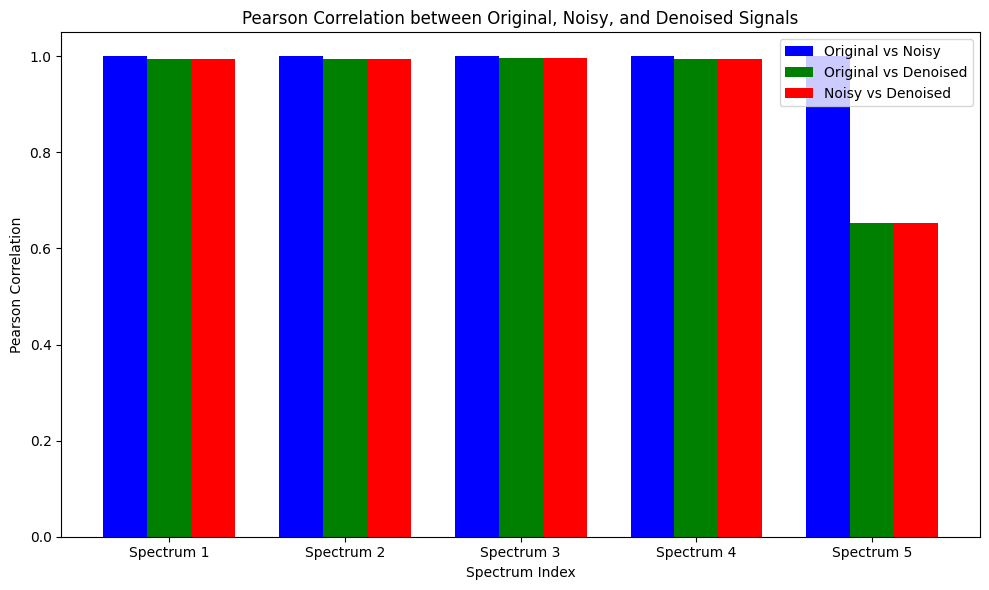

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Number of spectra to analyze
num_random_spectra = 5  
random_indices = np.random.choice(data.shape[0], num_random_spectra, replace=False)

# Lists to store the correlation values for plotting
corr_original_noisy_list = []
corr_original_denoised_list = []
corr_noisy_denoised_list = []

# Compute and store Pearson correlation for each randomly selected spectrum
for idx in random_indices:
    # Original Signal
    original_signal = data[idx, :]
    
    # Add noise to the original signal (Gaussian noise)
    noise = np.random.normal(0, 0.05, size=original_signal.shape)
    noisy_signal = original_signal + noise
    
    # Denoise the signal using a moving average filter
    window_size = 5
    denoised_signal = np.convolve(noisy_signal, np.ones(window_size)/window_size, mode='same')

    # Compute Pearson correlation between original and noisy signal
    corr_original_noisy, _ = pearsonr(original_signal, noisy_signal)
    
    # Compute Pearson correlation between original and denoised signal
    corr_original_denoised, _ = pearsonr(original_signal, denoised_signal)
    
    # Compute Pearson correlation between noisy and denoised signal
    corr_noisy_denoised, _ = pearsonr(noisy_signal, denoised_signal)

    # Append the correlation values to the lists for plotting
    corr_original_noisy_list.append(corr_original_noisy)
    corr_original_denoised_list.append(corr_original_denoised)
    corr_noisy_denoised_list.append(corr_noisy_denoised)

# Plotting the Pearson correlations for each spectrum
x = np.arange(num_random_spectra)  # X-axis positions for each spectrum
width = 0.25  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each correlation type
ax.bar(x - width, corr_original_noisy_list, width, label='Original vs Noisy', color='blue')
ax.bar(x, corr_original_denoised_list, width, label='Original vs Denoised', color='green')
ax.bar(x + width, corr_noisy_denoised_list, width, label='Noisy vs Denoised', color='red')

# Adding labels, title, and legend
ax.set_xlabel('Spectrum Index')
ax.set_ylabel('Pearson Correlation')
ax.set_title('Pearson Correlation between Original, Noisy, and Denoised Signals')
ax.set_xticks(x)
ax.set_xticklabels([f"Spectrum {i+1}" for i in range(num_random_spectra)])
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


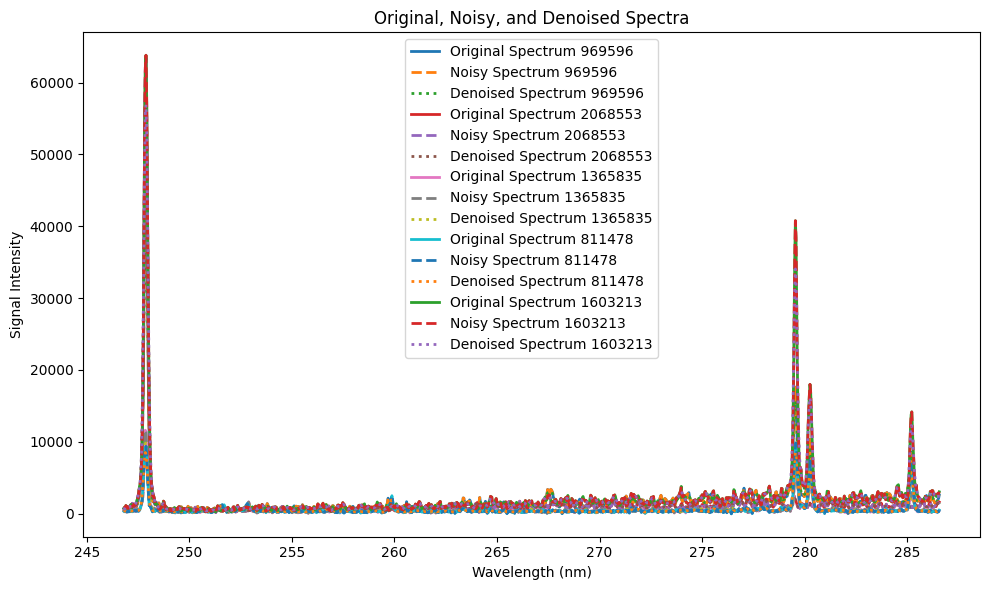

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Number of spectra to analyze
num_random_spectra = 5  
random_indices = np.random.choice(data.shape[0], num_random_spectra, replace=False)

# Plotting the original, noisy, and denoised signals for each randomly selected spectrum
plt.figure(figsize=(10, 6))

# Loop through each random index and plot the signals
for idx in random_indices:
    # Original Signal
    original_signal = data[idx, :]
    
    # Add noise to the original signal (Gaussian noise)
    noise = np.random.normal(0, 0.05, size=original_signal.shape)
    noisy_signal = original_signal + noise
    
    # Denoise the signal using a moving average filter
    window_size = 5
    denoised_signal = np.convolve(noisy_signal, np.ones(window_size)/window_size, mode='same')

    # Plot the signals
    plt.plot(wl, original_signal, label=f"Original Spectrum {idx+1}", linestyle='-', linewidth=2)
    plt.plot(wl, noisy_signal, label=f"Noisy Spectrum {idx+1}", linestyle='--', linewidth=2)
    plt.plot(wl, denoised_signal, label=f"Denoised Spectrum {idx+1}", linestyle=':', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal Intensity')
plt.title('Original, Noisy, and Denoised Spectra')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


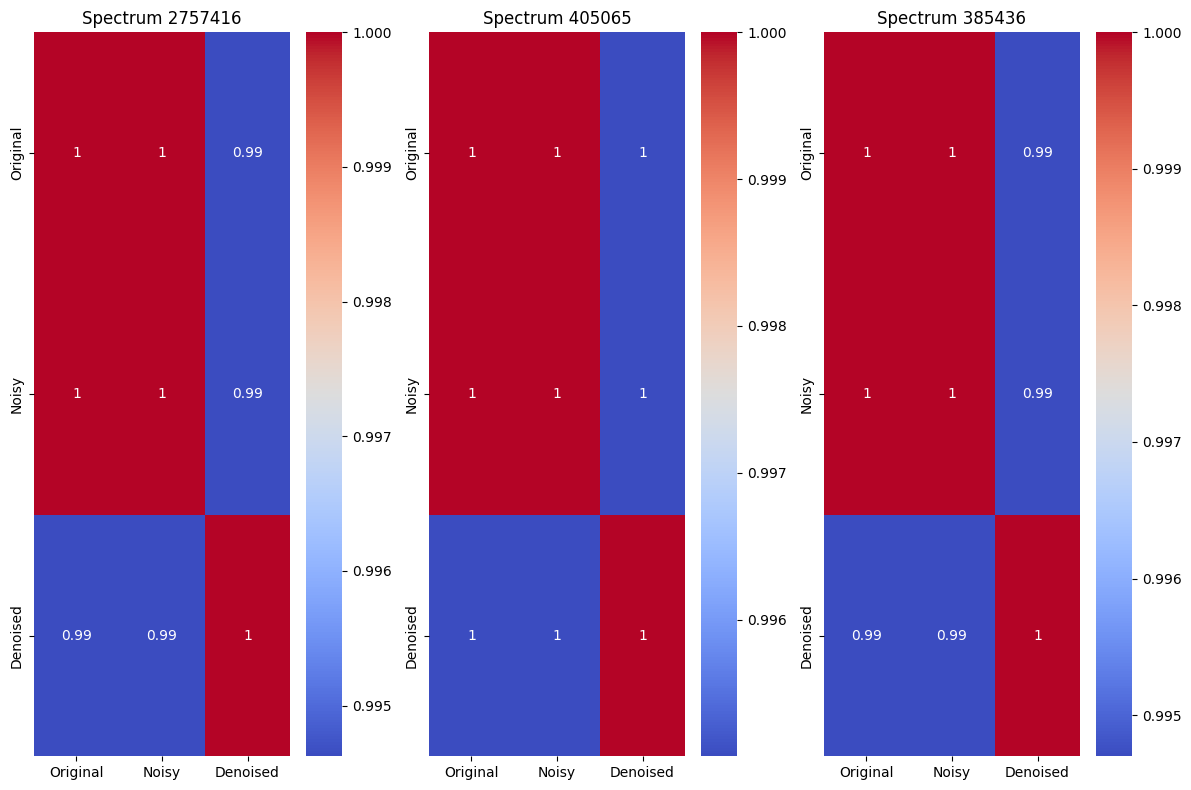

In [97]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Number of spectra to analyze
num_random_spectra = 3
random_indices = np.random.choice(data.shape[0], num_random_spectra, replace=False)

# Prepare to store the Pearson correlation coefficients for each spectrum
correlations = []

# Loop through each randomly selected spectrum
for idx in random_indices:
    # Original Signal
    original_signal = data[idx, :]
    
    # Add noise to the original signal (Gaussian noise)
    noise = np.random.normal(0, 0.05, size=original_signal.shape)
    noisy_signal = original_signal + noise
    
    # Denoise the signal using a moving average filter
    window_size = 5
    denoised_signal = np.convolve(noisy_signal, np.ones(window_size)/window_size, mode='same')

    # Compute the Pearson correlation for the three signals
    corr_matrix = np.corrcoef([original_signal, noisy_signal, denoised_signal])
    correlations.append(corr_matrix)

# Convert list of correlation matrices into a 3D array for easy plotting
correlations = np.array(correlations)

# Plotting the Pearson correlation for each selected spectrum
plt.figure(figsize=(12, 8))

for i, corr_matrix in enumerate(correlations):
    plt.subplot(1, num_random_spectra, i + 1)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=['Original', 'Noisy', 'Denoised'], yticklabels=['Original', 'Noisy', 'Denoised'])
    plt.title(f'Spectrum {random_indices[i]+1}')
    plt.tight_layout()

# Show the plot
plt.show()


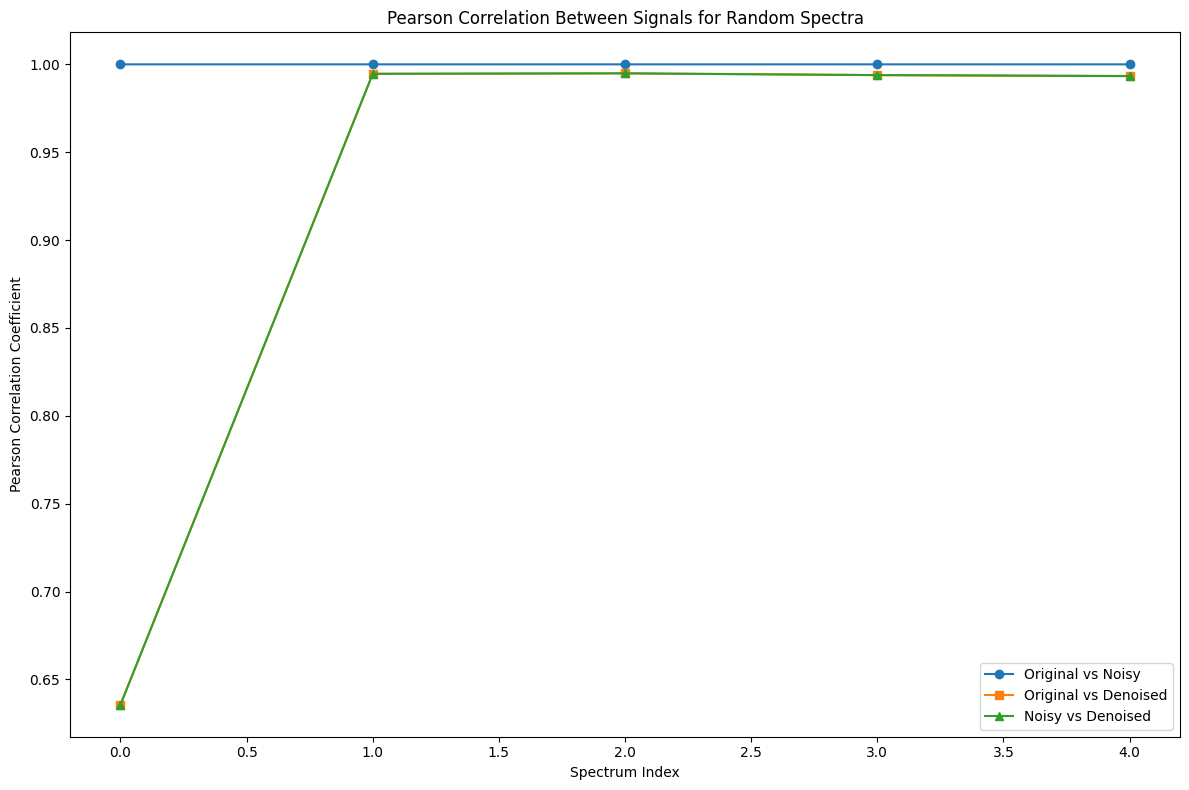

In [98]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Number of spectra to analyze
num_random_spectra = 5
random_indices = np.random.choice(data.shape[0], num_random_spectra, replace=False)

# Prepare to store Pearson correlation values for each spectrum
pearson_correlations = {'Original vs Noisy': [], 'Original vs Denoised': [], 'Noisy vs Denoised': []}

# Loop through each randomly selected spectrum
for idx in random_indices:
    # Original Signal
    original_signal = data[idx, :]
    
    # Add noise to the original signal (Gaussian noise)
    noise = np.random.normal(0, 0.05, size=original_signal.shape)
    noisy_signal = original_signal + noise
    
    # Denoise the signal using a moving average filter
    window_size = 5
    denoised_signal = np.convolve(noisy_signal, np.ones(window_size)/window_size, mode='same')

    # Compute Pearson correlation for the three signal pairs
    corr_original_noisy = np.corrcoef(original_signal, noisy_signal)[0, 1]
    corr_original_denoised = np.corrcoef(original_signal, denoised_signal)[0, 1]
    corr_noisy_denoised = np.corrcoef(noisy_signal, denoised_signal)[0, 1]

    # Append the correlation values to the lists
    pearson_correlations['Original vs Noisy'].append(corr_original_noisy)
    pearson_correlations['Original vs Denoised'].append(corr_original_denoised)
    pearson_correlations['Noisy vs Denoised'].append(corr_noisy_denoised)

# Plotting the Pearson correlation for each selected spectrum
plt.figure(figsize=(12, 8))

# Plot the Pearson correlation values
plt.plot(range(num_random_spectra), pearson_correlations['Original vs Noisy'], label='Original vs Noisy', marker='o')
plt.plot(range(num_random_spectra), pearson_correlations['Original vs Denoised'], label='Original vs Denoised', marker='s')
plt.plot(range(num_random_spectra), pearson_correlations['Noisy vs Denoised'], label='Noisy vs Denoised', marker='^')

# Add labels, title, and legend
plt.xlabel('Spectrum Index')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Pearson Correlation Between Signals for Random Spectra')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
